# Shot Probability Model

Many factors affect the chances that a field goal attempt will be successful. While not exhaustive, the following list contains a few:

- Shooting ability of the shooter
- Proximity (and number) of the closest defender(s)
- Shot location
- Shot type

The following introduces the `Player` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `shortchartdetail` and `playbyplay` endpoints of the [stats.nba.com](https://stats.nba.com). The goal of this analysis is to build a shot probability model that outperforms a baseline model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from IPython.display import IFrame

from py_ball import player, playbyplay

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `shotchartdetail` endpoint accepts a variety of parameters, but only a few are relevant for shot probability purposes:
- league_id: '00' for the NBA, '10' for the WNBA
- player_id: The unique identifier for the player (0 returns shot data for the whole game)
- game_id: The unique identifier for the game of interest
- season: YYYY-ZZ season year format (This only affects the league averages returned)

In [2]:
league_id = '00' #NBA
player_id = '0' #All players
game_id = '0021700608'
season = '2017-18'

shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season)
shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
shot_df.head(15)

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Jump Shot,Made Shot,20180110,7,0021700608,Shot Chart Detail,HOU,226,151,11,...,1,27,1,3PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,1610612745,Houston Rockets,POR
1,Pullup Jump shot,Missed Shot,20180110,9,0021700608,Shot Chart Detail,HOU,123,105,11,...,1,16,0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612757,Portland Trail Blazers,POR
2,Jump Shot,Missed Shot,20180110,11,0021700608,Shot Chart Detail,HOU,-162,187,11,...,1,24,0,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612745,Houston Rockets,POR
3,Jump Shot,Missed Shot,20180110,13,0021700608,Shot Chart Detail,HOU,144,253,10,...,1,29,0,3PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,1610612757,Portland Trail Blazers,POR
4,Driving Layup Shot,Missed Shot,20180110,15,0021700608,Shot Chart Detail,HOU,-29,6,10,...,1,2,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612745,Houston Rockets,POR
5,Pullup Jump shot,Missed Shot,20180110,18,0021700608,Shot Chart Detail,HOU,-214,126,10,...,1,24,0,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612745,Houston Rockets,POR
6,Jump Shot,Missed Shot,20180110,20,0021700608,Shot Chart Detail,HOU,-242,62,10,...,1,24,0,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,1610612757,Portland Trail Blazers,POR
7,Turnaround Fadeaway shot,Made Shot,20180110,22,0021700608,Shot Chart Detail,HOU,57,88,10,...,1,10,1,2PT Field Goal,Right Side(R),In The Paint (Non-RA),8-16 ft.,1610612745,Houston Rockets,POR
8,Layup Shot,Missed Shot,20180110,23,0021700608,Shot Chart Detail,HOU,-2,62,9,...,1,6,0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612757,Portland Trail Blazers,POR
9,Driving Finger Roll Layup Shot,Missed Shot,20180110,25,0021700608,Shot Chart Detail,HOU,-11,31,9,...,1,3,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612745,Houston Rockets,POR


In [3]:
list(shot_df)

['ACTION_TYPE',
 'EVENT_TYPE',
 'GAME_DATE',
 'GAME_EVENT_ID',
 'GAME_ID',
 'GRID_TYPE',
 'HTM',
 'LOC_X',
 'LOC_Y',
 'MINUTES_REMAINING',
 'PERIOD',
 'PLAYER_ID',
 'PLAYER_NAME',
 'SECONDS_REMAINING',
 'SHOT_ATTEMPTED_FLAG',
 'SHOT_DISTANCE',
 'SHOT_MADE_FLAG',
 'SHOT_TYPE',
 'SHOT_ZONE_AREA',
 'SHOT_ZONE_BASIC',
 'SHOT_ZONE_RANGE',
 'TEAM_ID',
 'TEAM_NAME',
 'VTM']

Looks like the `shotchartdetail` endpoint has shot location (including zone and coordinates) and type. However, defender and shot clock information do not seem to be available. To calculate shooter ability, the `playerdashboardbyshootingsplits` endpoint may be of use.

In [4]:
shooters = player.Player(headers=HEADERS,
                         endpoint='playerdashboardbyshootingsplits',
                         league_id=league_id,
                         player_id='2772',
                         season=season)
shot_type_df = pd.DataFrame(shooters.data['ShotTypePlayerDashboard'])
shot_type_df.head(10)

,BLKA,BLKA_RANK,CFID,CFPARAMS,EFG_PCT,EFG_PCT_RANK,FG3A,FG3A_RANK,FG3M,FG3M_RANK,...,PCT_AST_3PM,PCT_AST_3PM_RANK,PCT_AST_FGM,PCT_AST_FGM_RANK,PCT_UAST_2PM,PCT_UAST_2PM_RANK,PCT_UAST_3PM,PCT_UAST_3PM_RANK,PCT_UAST_FGM,PCT_UAST_FGM_RANK
0,0,1,50,Alley Oop Dunk Shot,0.000,24,0,8,0,8,...,0.0,8,0.000,21,0.000,15,0.0,5,0.000,18
1,0,1,50,Alley Oop Layup shot,0.000,24,0,8,0,8,...,0.0,8,0.000,21,0.000,15,0.0,5,0.000,18
2,0,1,50,Cutting Dunk Shot,1.000,3,0,8,0,8,...,0.0,8,1.000,1,0.000,15,0.0,5,0.000,18
3,0,1,50,Cutting Finger Roll Layup Shot,0.000,24,0,8,0,8,...,0.0,8,0.000,21,0.000,15,0.0,5,0.000,18
4,2,40,50,Cutting Layup Shot,0.667,16,0,8,0,8,...,0.0,8,1.000,1,0.000,15,0.0,5,0.000,18
5,0,1,50,Driving Bank Hook Shot,0.000,24,0,8,0,8,...,0.0,8,0.000,21,0.000,15,0.0,5,0.000,18
6,0,1,50,Driving Dunk Shot,1.000,3,0,8,0,8,...,0.0,8,0.833,8,0.167,14,0.0,5,0.167,16
7,0,1,50,Driving Finger Roll Layup Shot,0.909,10,0,8,0,8,...,0.0,8,0.800,9,0.200,13,0.0,5,0.200,15
8,0,1,50,Driving Floating Bank Jump Shot,0.750,13,0,8,0,8,...,0.0,8,0.667,11,0.333,11,0.0,5,0.333,11
9,3,43,50,Driving Floating Jump Shot,0.250,23,0,8,0,8,...,0.0,8,0.500,15,0.500,9,0.0,5,0.500,7


In [5]:
list(shot_type_df)

['BLKA',
 'BLKA_RANK',
 'CFID',
 'CFPARAMS',
 'EFG_PCT',
 'EFG_PCT_RANK',
 'FG3A',
 'FG3A_RANK',
 'FG3M',
 'FG3M_RANK',
 'FG3_PCT',
 'FG3_PCT_RANK',
 'FGA',
 'FGA_RANK',
 'FGM',
 'FGM_RANK',
 'FG_PCT',
 'FG_PCT_RANK',
 'GROUP_SET',
 'GROUP_VALUE',
 'PCT_AST_2PM',
 'PCT_AST_2PM_RANK',
 'PCT_AST_3PM',
 'PCT_AST_3PM_RANK',
 'PCT_AST_FGM',
 'PCT_AST_FGM_RANK',
 'PCT_UAST_2PM',
 'PCT_UAST_2PM_RANK',
 'PCT_UAST_3PM',
 'PCT_UAST_3PM_RANK',
 'PCT_UAST_FGM',
 'PCT_UAST_FGM_RANK']

The `shot_type_df` has a `CFPARAMS` field which seems to correspond to `ACTION_TYPE` in `shot_df`.

In [6]:
list(set(shot_df['ACTION_TYPE']))

['Putback Dunk Shot',
 'Hook Shot',
 'Running Layup Shot',
 'Turnaround Fadeaway Bank Jump Shot',
 'Cutting Layup Shot',
 'Driving Finger Roll Layup Shot',
 'Step Back Jump shot',
 'Reverse Layup Shot',
 'Turnaround Fadeaway shot',
 'Jump Shot',
 'Tip Layup Shot',
 'Alley Oop Dunk Shot',
 'Driving Floating Jump Shot',
 'Pullup Jump shot',
 'Layup Shot',
 'Driving Reverse Layup Shot',
 'Driving Dunk Shot',
 'Cutting Dunk Shot',
 'Running Reverse Layup Shot',
 'Fadeaway Jump Shot',
 'Floating Jump shot',
 'Putback Layup Shot',
 'Turnaround Jump Shot',
 'Dunk Shot',
 'Driving Layup Shot']

In [7]:
list(set(shot_type_df['CFPARAMS']))

['Running Jump Shot',
 'Putback Dunk Shot',
 'Turnaround Hook Shot',
 'Hook Shot',
 'Driving Floating Bank Jump Shot',
 'Driving Bank Hook Shot',
 'Running Layup Shot',
 'Driving Hook Shot',
 'Driving Reverse Dunk Shot',
 'Running Alley Oop Layup Shot',
 'Turnaround Fadeaway Bank Jump Shot',
 'Cutting Layup Shot',
 'Driving Finger Roll Layup Shot',
 'Running Dunk Shot',
 'Hook Bank Shot',
 'Step Back Jump shot',
 'Reverse Layup Shot',
 'Turnaround Fadeaway shot',
 'Jump Shot',
 'Alley Oop Dunk Shot',
 'Tip Layup Shot',
 'Driving Floating Jump Shot',
 'Pullup Jump shot',
 'Step Back Bank Jump Shot',
 'Running Finger Roll Layup Shot',
 'Alley Oop Layup shot',
 'Turnaround Bank Hook Shot',
 'Running Alley Oop Dunk Shot',
 'Layup Shot',
 'Reverse Dunk Shot',
 'Finger Roll Layup Shot',
 'Driving Reverse Layup Shot',
 'Cutting Finger Roll Layup Shot',
 'Tip Dunk Shot',
 'Driving Dunk Shot',
 'Cutting Dunk Shot',
 'Running Reverse Layup Shot',
 'Fadeaway Jump Shot',
 'Floating Jump shot',
 'P

In [8]:
shot_area_df = pd.DataFrame(shooters.data['ShotAreaPlayerDashboard'])
shot_area_df.head(10)

,BLKA,BLKA_RANK,CFID,CFPARAMS,EFG_PCT,EFG_PCT_RANK,FG3A,FG3A_RANK,FG3M,FG3M_RANK,...,PCT_AST_3PM,PCT_AST_3PM_RANK,PCT_AST_FGM,PCT_AST_FGM_RANK,PCT_UAST_2PM,PCT_UAST_2PM_RANK,PCT_UAST_3PM,PCT_UAST_3PM_RANK,PCT_UAST_FGM,PCT_UAST_FGM_RANK
0,12,7,49,Restricted Area,0.608,3,0,6,0,4,...,0.00,4,0.602,4,0.398,3,0.00,2,0.398,3
1,8,6,49,In The Paint (Non-RA),0.148,5,0,6,0,4,...,0.00,4,0.500,5,0.500,2,0.00,2,0.500,2
2,0,1,49,Mid-Range,0.111,6,1,5,0,4,...,0.00,4,0.000,6,1.000,1,0.00,2,1.000,1
3,0,1,49,Left Corner 3,0.640,2,75,3,32,3,...,1.00,1,1.000,1,0.000,4,0.00,2,0.000,5
4,0,1,49,Right Corner 3,0.650,1,113,2,49,2,...,1.00,1,1.000,1,0.000,4,0.00,2,0.000,5
5,1,5,49,Above the Break 3,0.491,4,271,1,89,1,...,0.91,3,0.910,3,0.000,4,0.09,1,0.090,4
6,0,1,49,Backcourt,0.000,7,2,4,0,4,...,0.00,4,0.000,6,0.000,4,0.00,2,0.000,5


After observing some of the potential features available, this shot probability model will go forward with the following features:
   - Shot distance
   - Angle to basket (0 degrees is straight on, 45 degrees is baseline)
   - Side of basket
   - Action type
   
These features are available directly from the `shotchartdetail` endpoint, so the following cell contains a function to generate those features.

In [9]:
def feature_engineering(shotchart_df):
    """ feature_engineering calculates engineered
    features from the shotchart data

    @param shotchart_df (DataFrame): DataFrame containing
    shotchart data

    Returns:

        shotchart_df (DataFrame): DataFrame containing
        the engineered features
    """

    shotchart_df['ANGLE'] = abs(np.rad2deg(np.arctan2(shotchart_df['LOC_X'],
                                                      shotchart_df['LOC_Y'])))

    shotchart_df['SIDE'] = [1 if x >= 0 else 0 for x in shotchart_df['LOC_X']]

    shotchart_df['DUNK'] = [1 if 'Dunk' in x else 0 for x in shotchart_df['ACTION_TYPE']]
    shotchart_df['HOOK'] = [1 if 'Hook' in x else 0 for x in shotchart_df['ACTION_TYPE']]
    shotchart_df['LAYUP'] = [1 if 'Layup' in x else 0 for x in shotchart_df['ACTION_TYPE']]
    shotchart_df['JUMP'] = [1 if 'Jump' in x else 0 for x in shotchart_df['ACTION_TYPE']]

    shotchart_df = shotchart_df[['SHOT_DISTANCE', 'ANGLE', 'SIDE', 'DUNK', 'HOOK', 'LAYUP', 'JUMP', 'SHOT_MADE_FLAG']]

    return shotchart_df

In [10]:
shot_df = feature_engineering(shot_df)

In [11]:
shot_df

,SHOT_DISTANCE,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,SHOT_MADE_FLAG
0,27,56.251467,1,0,0,0,1,1
1,16,49.513988,1,0,0,0,1,0
2,24,40.902716,0,0,0,0,1,0
3,29,29.647232,1,0,0,0,1,0
4,2,78.310631,0,0,0,1,0,0
5,24,59.511060,0,0,0,0,1,0
6,24,75.629998,0,0,0,0,1,0
7,10,32.932231,1,0,0,0,0,1
8,6,1.847610,0,0,0,1,0,0
9,3,19.536655,0,0,0,1,0,0


The above handles the feature engineering of all desired features. Gathering more data would be the next step. The next cell contains functions that pull shot chart data for an entire NBA regular season. For the sake of time, the 2017-18 season shotchart data has been pulled and is stored in this repository in the `shotchart_2017.csv` file.

In [12]:
def pad_id(num):
    """ pad_id adds the requisite number of leading
    zeroes to a game number to form a valid game_id

    @param num (int): Regular season game number

    Returns:

        num_str (str): Regular season game number
        with leading zeroes
    """
    
    num_str = str(num)
    while len(num_str) < 4:
        num_str = '0' + num_str
        
    return num_str


def get_year_shotcharts(year):
    """ get_year_shotcharts pulls data from the
    shotchartdetail endpoint of the stats.nba.com API

    @param year (int): year corresponding to the year
    in which the season began. For example, the 2017-2018
    NBA season is represented as the year 2017.

    Returns:

        Saves a .csv file of the shotchart data to the
        current working directory with a name formatted
        as shotchart_[year].csv
    """

    year_sub = str(year)[-2:]

    base = '002' + year_sub + '0'

    all_df = pd.DataFrame({})

    for x in range(1, 1231):
        print('Game #' + str(x))
        game_id_here = base + pad_id(x)

        t0 = time.time()
        shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id_here,
                      season=season)

        shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
        delay = time.time() - t0
        print('Waiting ' + str(10*delay) + 's')
        time.sleep(delay)

        all_df = pd.concat([all_df, shot_df], axis=0).reset_index(drop=True)

    all_df.to_csv('shotchart_'+str(year)+'.csv', index=False)

In [13]:
all_shots_df = pd.read_csv('shotchart_2017.csv')

In [14]:
all_shots_df

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Driving Floating Jump Shot,Made Shot,20171017,7,21700001,Shot Chart Detail,CLE,-1,100,11,...,1,10,1,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612738,Boston Celtics,BOS
1,Layup Shot,Missed Shot,20171017,9,21700001,Shot Chart Detail,CLE,-18,4,11,...,1,1,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612739,Cleveland Cavaliers,BOS
2,Jump Shot,Missed Shot,20171017,12,21700001,Shot Chart Detail,CLE,-214,138,11,...,1,25,0,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612738,Boston Celtics,BOS
3,Jump Shot,Missed Shot,20171017,14,21700001,Shot Chart Detail,CLE,-131,83,11,...,1,15,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612739,Cleveland Cavaliers,BOS
4,Cutting Layup Shot,Missed Shot,20171017,16,21700001,Shot Chart Detail,CLE,10,23,10,...,1,2,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612738,Boston Celtics,BOS
5,Jump Shot,Made Shot,20171017,20,21700001,Shot Chart Detail,CLE,47,190,10,...,1,19,1,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,1610612738,Boston Celtics,BOS
6,Jump Shot,Made Shot,20171017,24,21700001,Shot Chart Detail,CLE,217,56,10,...,1,22,1,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612739,Cleveland Cavaliers,BOS
7,Turnaround Fadeaway shot,Made Shot,20171017,29,21700001,Shot Chart Detail,CLE,-117,35,9,...,1,12,1,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612739,Cleveland Cavaliers,BOS
8,Driving Dunk Shot,Missed Shot,20171017,31,21700001,Shot Chart Detail,CLE,-11,6,9,...,1,1,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612738,Boston Celtics,BOS
9,Running Layup Shot,Made Shot,20171017,33,21700001,Shot Chart Detail,CLE,-5,11,9,...,1,1,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612739,Cleveland Cavaliers,BOS


In [15]:
features_df = feature_engineering(all_shots_df)

In [16]:
features_df.SHOT_MADE_FLAG.value_counts()

0    114272
1     97435
Name: SHOT_MADE_FLAG, dtype: int64

Looks like the dataset has over 200,000 shots! The above shows a fairly even split between made shots (1) and missed shots (0). The following cells build a random forest classifier to predict the probability of a shot going in. First, let's split the dataset into a training and test set.

In [17]:
output = list(features_df['SHOT_MADE_FLAG'])
features_df = features_df.drop(['SHOT_MADE_FLAG'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features_df, output, test_size=0.1, random_state=489)

Establishing a baseline model provides a basis for comparison to any subsequent models built to assess improvement in prediction. A simple baseline would be to use a constant shooting percentage from the training set.

In [18]:
sum(y_train)/float(len(y_train))

0.46008628290716713

With the above baseline model established, the following uses the `GridSearchCV` function from `sklearn` to perform hyperparameter tuning for the random forest model (`RandomForestClassifier`). 5-fold cross validation searches for the best hyperparameter combination through an exhaustive grid search. The grid search consists of:
- `n_estimators`: number of trees in the random forest
- `min_samples_leaf`: the minimum number of observations to be included in a leaf node
- `max_depth`: the maximum depth of a tree within the forest

Note, the grid search is time consuming as each combination of parameters is explored via cross validation. For the sake of time, the optimal parameters resulting from the cross validation are provided.

In [19]:
parameters = {'n_estimators':[200],
              'max_depth': [10],
              'min_samples_leaf': [50]}
rf_classifier = RandomForestClassifier(random_state=3409)
clf = GridSearchCV(rf_classifier, parameters, cv=5, scoring='neg_log_loss')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=3409,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'max_depth': [10], 'min_samples_leaf': [50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [20]:
rf_best = clf.best_estimator_
print('Best random forest with n_estimators = ' + str(rf_best.n_estimators) + ', max_depth = ' + str(rf_best.max_depth) +
    ', and min_samples_leaf = ' + str(rf_best.min_samples_leaf) + ' for a CV negative log loss score of ' + str(clf.best_score_))

Best random forest with n_estimators = 200, max_depth = 10, and min_samples_leaf = 50 for a CV negative log loss score of -0.641461230195


In [21]:
pd.DataFrame({'Feature': list(X_train), 'Importance': rf_best.feature_importances_})

,Feature,Importance
0,SHOT_DISTANCE,0.502317
1,ANGLE,0.074228
2,SIDE,0.002781
3,DUNK,0.216754
4,HOOK,0.007191
5,LAYUP,0.067534
6,JUMP,0.129196


With the hyperparameters of the random forest tuned, the best model has been chosen. The feature importance table above illustrates how the model predicts shot probability. The `SHOT_DISTANCE` feature is the most important feature, which is quite intuitive. Interestingly, the `SIDE` of the basket from which a shot is taken is the least important feature to the model.

How much has this model improved upon the baseline? Let's see.

In [22]:
model_test_preds = rf_best.predict_proba(X_test)
model_test_preds = [x[1] for x in model_test_preds]
base_test_preds = [0.46]*len(y_test)

print('Baseline log loss:')
print(log_loss(y_test, base_test_preds))

print('******************')
print('Model log loss:')
print(log_loss(y_test, model_test_preds))

Baseline log loss:
0.690196265376
******************
Model log loss:
0.642883387162


In [23]:
(0.690196 - 0.642883)/(0.690196)

0.0685500930170561

The above shows that our random forest model improves upon the baseline by 6.9%! Beyond the aggregate, examining the test set directly provides further evidence of a healthy model.

In [24]:
X_test['model_pred'] = model_test_preds
X_test['SHOT_MADE_FLAG'] = y_test

In [25]:
X_test.sort_values('model_pred', ascending=False)

,SHOT_DISTANCE,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,model_pred,SHOT_MADE_FLAG
34419,0,15.945396,0,1,0,0,0,0.968947,1
66551,0,15.945396,0,1,0,0,0,0.968947,1
146696,0,15.945396,0,1,0,0,0,0.968947,1
70153,0,15.945396,0,1,0,0,0,0.968947,1
97359,0,32.005383,1,1,0,0,0,0.968525,1
75535,0,32.005383,1,1,0,0,0,0.968525,1
111894,0,32.005383,1,1,0,0,0,0.968525,1
81412,0,40.601295,1,1,0,0,0,0.967788,0
178613,0,39.805571,1,1,0,0,0,0.967749,1
106331,0,39.805571,1,1,0,0,0,0.967749,1


The above shows the test set ordered by our predicted shot probability. The highest probability shots are all dunks, while the lowest probability shots are all jump shots from a great distance (likely desperation heaves). The model seems to be doing a good job of separating high and low probability shots. While this is a good sanity check, a more visual inspection should give a comprehensive look at the model. To start, we will need a function that generates a court visual.

In [26]:
def draw_court():
    """ draw_court draws an NBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an NBA court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 90], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 90], 'k-') # 3pt straight

    three_point = Arc((0, 0), width=237.5*2, height=237.5*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

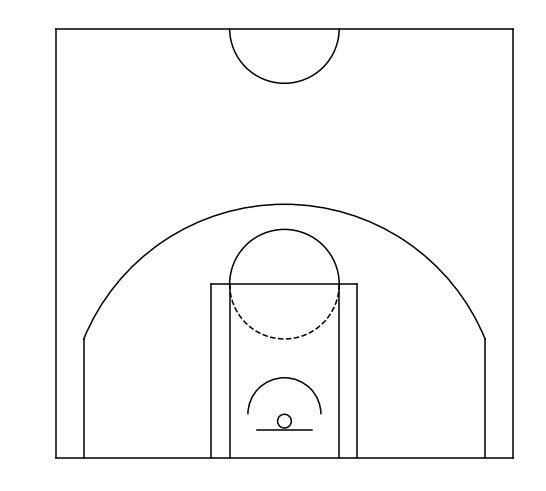

In [27]:
court, court_axis = draw_court()
court

The coordinate system returned from the `shotchartdetail` endpoint has its origin at the basket and the units of each cooridndate are feet times 10 (description [here](https://rdrr.io/github/llefebure/nba-stats/man/courtOutline.html)). For example, a 10 foot shoot from straight on would be taken from `LOC_X = 0` and `LOC_Y = 100`. Additionally, the reported `LOC_X` locations are flipped with negative values of `LOC_X` corresponding to the left side of the basket if facing it from the court. The court visual above has negative values of `LOC_X` corresponding to the right side of the basket if facing it from the court. To adjust for this, we can flip the sign on all `LOC_X` values.

In [28]:
def plot_shot(shot):
    """ plot_shot plots a shot or list of shots given in the
    shot DataFrame provided

    @param shot (DataFrame): DataFrame of shots with LOC_X and
        LOC_Y columns

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the shots plotted
    """
    court, court_axis = draw_court()
    miss_df = shot[shot['SHOT_MADE_FLAG']==0]
    make_df = shot[shot['SHOT_MADE_FLAG']==1]

    if len(make_df)>0:
        court_axis.plot(-make_df['LOC_X'], make_df['LOC_Y'], 'ko')
    if len(miss_df)>0:
        court_axis.plot(-miss_df['LOC_X'], miss_df['LOC_Y'], 'kx')

    plt.close()
    return court

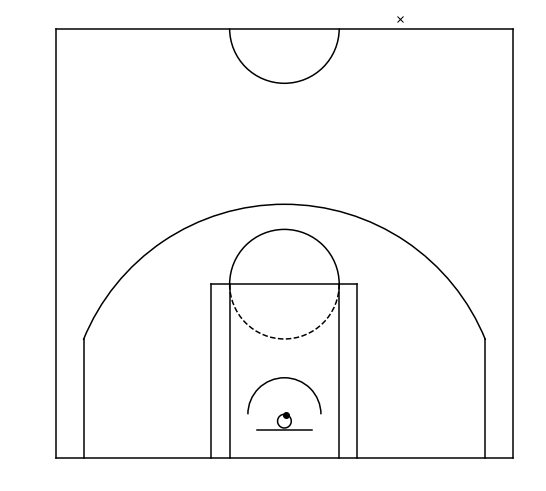

In [29]:
plot_shot(all_shots_df.loc[[178745, 34419]])

The above chart shows two shots, one with a 97% make probability (marked with a dot) and another with a 5% make probability (marked with an x). Again, this serves as a visualization to confirm that the model performs well in the extremes. A heatmap will allow for an examination of model performance from all areas. The function below, `model_heatmap`, plots the make probability of a given shot type from all locations in the halfcourt.

In [30]:
def model_heatmap(shot_type, shot_model):
    """ model_heatmap plots the make probability
    of a given shot_type from all relevant locations.

    @param shot_type (str): Shot type equal to one
        of 'DUNK', 'LAYUP', 'HOOK', or 'JUMP'

    @param shot_model (sklearn.ensemble.forest.RandomForestClassifier):
        Shot probability model
    Returns:

        heatmap (maplotlib.figure.Figure): Court visual with
            the heatmap plotted
    """

    if shot_type == 'JUMP':
        x_vals = list(range(-250, 250, 3))
        y_vals = list(range(0, 430, 3))
    else:
        x_vals = list(range(-100, 100, 1))
        y_vals = list(range(0, 100, 1))

    coordinate_vals = list(itertools.product(x_vals, y_vals))

    model_df = pd.DataFrame(coordinate_vals, columns=['LOC_X', 'LOC_Y'])
    model_df['SHOT_DISTANCE'] = np.sqrt((model_df['LOC_X']/10.0)**2 + (model_df['LOC_Y']/10.0)**2)
    if shot_type != 'JUMP':
        model_df = model_df[model_df['SHOT_DISTANCE']<=10]

    model_df['ANGLE'] = abs(np.rad2deg(np.arctan2(model_df['LOC_X'],
                                                  model_df['LOC_Y'])))

    model_df['SIDE'] = [1 if x >= 0 else 0 for x in model_df['LOC_X']]
    for shot_types in ['DUNK', 'LAYUP', 'HOOK', 'JUMP']:
        if shot_type == shot_types:
            model_df[shot_types] = [1]*len(model_df)
        else:
            model_df[shot_types] = [0]*len(model_df)

    features_df = model_df[['SHOT_DISTANCE', 'ANGLE', 'SIDE', 'DUNK', 'HOOK', 'LAYUP', 'JUMP']]
    model_test_preds = shot_model.predict_proba(features_df)
    model_df['shot_prob'] = [x[1] for x in model_test_preds]

    heatmap, heatmap_axis = draw_court()

    hm = heatmap_axis.scatter(-model_df['LOC_X'], model_df['LOC_Y'],
                              c=model_df['shot_prob'], cmap='coolwarm', vmin=0, vmax=1)
    cbar = heatmap.colorbar(hm)
    cbar.set_clim(vmin=0, vmax=1)
    cbar.set_label(label='Shot Probability', fontsize=14)
    plt.title(shot_type.title() + ' Shot Probability', fontsize=14)
    plt.close()
    return heatmap

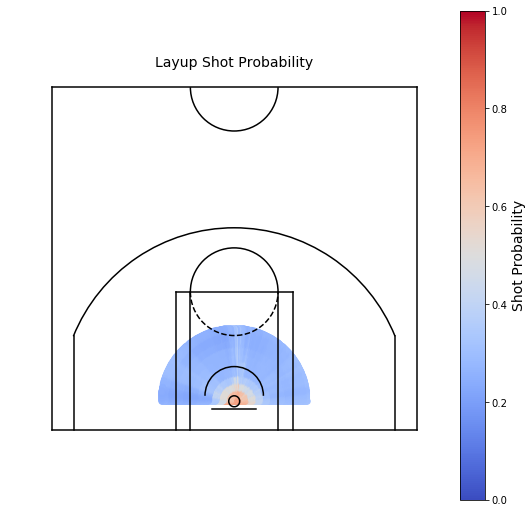

In [31]:
model_heatmap('LAYUP', rf_best)

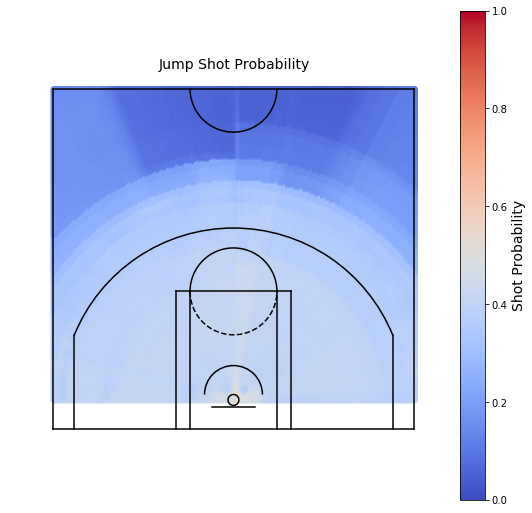

In [32]:
model_heatmap('JUMP', rf_best)

The above two charts reveal the nuance captured by the shot probability model. For a jump shot, the probability of making a shot decreases gradually as the distance from the basket increases. This provides credence to the three-point field goal revolution as the gradual decrease in shot probability is overcome by the increased value of a three-point field goal. A sharp decline in shot probability occurs well beyond the three-point line according to this model. For a layup, the probability of making a shot drops precipitously beyond the immediate vicinity of the hoop.

## Shot Videos

What better way to explore a shot probability model than to view videos of the actual shots? The code below predicts the shot probability for all shots available, and then prints the URL for particularly interesting shots.

In [33]:
all_preds = rf_best.predict_proba(features_df)
all_preds = [x[1] for x in all_preds]
all_shots_df['shot_prob'] = all_preds

In [34]:
all_shots_df.sort_values('shot_prob')

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,TEAM_ID,TEAM_NAME,VTM,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,shot_prob
156157,Running Jump Shot,Missed Shot,20180227,153,21700912,Shot Chart Detail,DEN,-41,575,0,...,1610612743,Denver Nuggets,LAC,4.078535,0,0,0,0,1,0.043087
152289,Jump Shot,Missed Shot,20180224,687,21700889,Shot Chart Detail,PHX,-43,583,0,...,1610612756,Phoenix Suns,POR,4.218294,0,0,0,0,1,0.043144
135589,Running Jump Shot,Missed Shot,20180205,418,21700794,Shot Chart Detail,DEN,-40,572,0,...,1610612743,Denver Nuggets,CHA,4.000186,0,0,0,0,1,0.043228
5183,Jump Shot,Missed Shot,20171021,316,21700030,Shot Chart Detail,NYK,-117,525,0,...,1610612752,New York Knicks,DET,12.563469,0,0,0,0,1,0.043561
12996,Running Jump Shot,Missed Shot,20171027,475,21700076,Shot Chart Detail,LAL,-34,529,0,...,1610612747,Los Angeles Lakers,TOR,3.677468,0,0,0,0,1,0.043589
186360,Jump Shot,Missed Shot,20180323,721,21701085,Shot Chart Detail,SAS,-111,488,0,...,1610612762,Utah Jazz,UTA,12.814415,0,0,0,0,1,0.043646
162091,Jump Shot,Missed Shot,20180304,351,21700946,Shot Chart Detail,DAL,-35,549,0,...,1610612740,New Orleans Pelicans,NOP,3.647800,0,0,0,0,1,0.043787
81154,Running Jump Shot,Missed Shot,20171222,662,21700477,Shot Chart Detail,OKC,-122,537,0,...,1610612737,Atlanta Hawks,ATL,12.799654,0,0,0,0,1,0.043845
160298,Jump Shot,Missed Shot,20180303,142,21700936,Shot Chart Detail,ORL,-45,520,0,...,1610612763,Memphis Grizzlies,MEM,4.945967,0,0,0,0,1,0.043858
73636,Jump Shot,Missed Shot,20171216,175,21700433,Shot Chart Detail,HOU,-29,504,0,...,1610612745,Houston Rockets,MIL,3.293150,0,0,0,0,1,0.043927


### Highest Probability Missed Shot

In [35]:
all_shots_df[all_shots_df['SHOT_MADE_FLAG']==0].sort_values('shot_prob').tail(1)

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,TEAM_ID,TEAM_NAME,VTM,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,shot_prob
81412,Dunk Shot,Missed Shot,20171222,321,21700479,Shot Chart Detail,GSW,6,7,0,...,1610612744,Golden State Warriors,LAL,40.601295,1,1,0,0,0,0.967788


In [36]:
print('https://stats.nba.com/events/?flag=1&GameID=00{game_id}&GameEventID={event_id}&Season=2017-18&sct=plot'.format(game_id=21700479,
                                                                                                                      event_id=321))

https://stats.nba.com/events/?flag=1&GameID=0021700479&GameEventID=321&Season=2017-18&sct=plot


### Lowest Probability Made Shot

The first two shots either have missing video or erroneous data.

In [37]:
all_shots_df[all_shots_df['SHOT_MADE_FLAG']==1].sort_values('shot_prob').iloc[2]

ACTION_TYPE            Running Jump Shot
EVENT_TYPE                     Made Shot
GAME_DATE                       20180222
GAME_EVENT_ID                        335
GAME_ID                         21700872
GRID_TYPE              Shot Chart Detail
HTM                                  GSW
LOC_X                               -117
LOC_Y                                408
MINUTES_REMAINING                      0
PERIOD                                 2
PLAYER_ID                         201568
PLAYER_NAME             Danilo Gallinari
SECONDS_REMAINING                      1
SHOT_ATTEMPTED_FLAG                    1
SHOT_DISTANCE                         42
SHOT_MADE_FLAG                         1
SHOT_TYPE                 3PT Field Goal
SHOT_ZONE_AREA            Back Court(BC)
SHOT_ZONE_BASIC        Above the Break 3
SHOT_ZONE_RANGE          Back Court Shot
TEAM_ID                       1610612746
TEAM_NAME                    LA Clippers
VTM                                  LAC
ANGLE           

In [38]:
print('https://stats.nba.com/events/?flag=1&GameID=00{game_id}&GameEventID={event_id}&Season=2017-18&sct=plot'.format(game_id=21700872,
                                                                                                                      event_id=335))

https://stats.nba.com/events/?flag=1&GameID=0021700872&GameEventID=335&Season=2017-18&sct=plot


## Exploration

- This notebook mentions several other factors that affect shot probability but are not included in the model. Can you name more or incorporate them in a better model?
- This exercise contained several modeling assumptions, including the feature engineering choices and using a random forest model. Challenge one of these assumptions to take the analysis further.